# Jupiter Notebook for measuring the penetration behavior of water through paper
Step by step code presentation

---
## Authors
Anne-Marie Kröher,Luisa Schueller, Peter Krutzke, Coding support by Robert Unger

---
## Init
Import all classes and functions

In [1]:
# Makes plotting beauty
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
import seaborn as sns 

sns.set(style="darkgrid")

from options import Options
from pwp import PaperWaterPenetration

pwp = PaperWaterPenetration()
import calc
import image

---
## Capturing images from camera
Define your intervals as a list of tuples(duration, interval).
You can also set Debug if needed.

If you wish to convert every image to gray scale, set convert param to True. Of course you can also perform the conversion process afterwards

In [ ]:
# set log level to debug
#log = get_logger("capture")
# Uncomment if you want logging
#log.setLevel(logging.DEBUG)

pwp.capture()

---
## Fast Fourier Transformation
Load image and transform. Example on one image. There is also a batch process.
For the example demo we use our dummy image lena.png
For our proper use case we can load the images directly from our image cache.

IMPORTANT! We need to load image as 2D array. When reading image as gray scale, , this happens automatically.

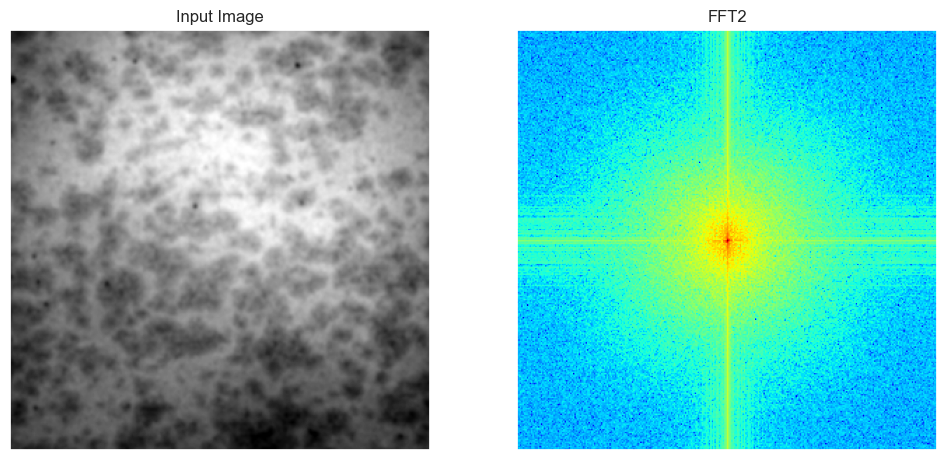

In [2]:
img_orginal = image.image_read_gray("../example/test_gray.png") # Need to load as gray scale (2D Array image)

# fft2 transformation
img_fft2 = calc.fft2_transformer(img_orginal)

plt.subplot(221), plt.imshow(img_orginal, cmap="gray")
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img_fft2, cmap="jet")
plt.title('FFT2'), plt.xticks([]), plt.yticks([])
plt.show()

---
## Radial Profile
Calculating radial profile and plot. For this step we used the processed img_fft2 variable

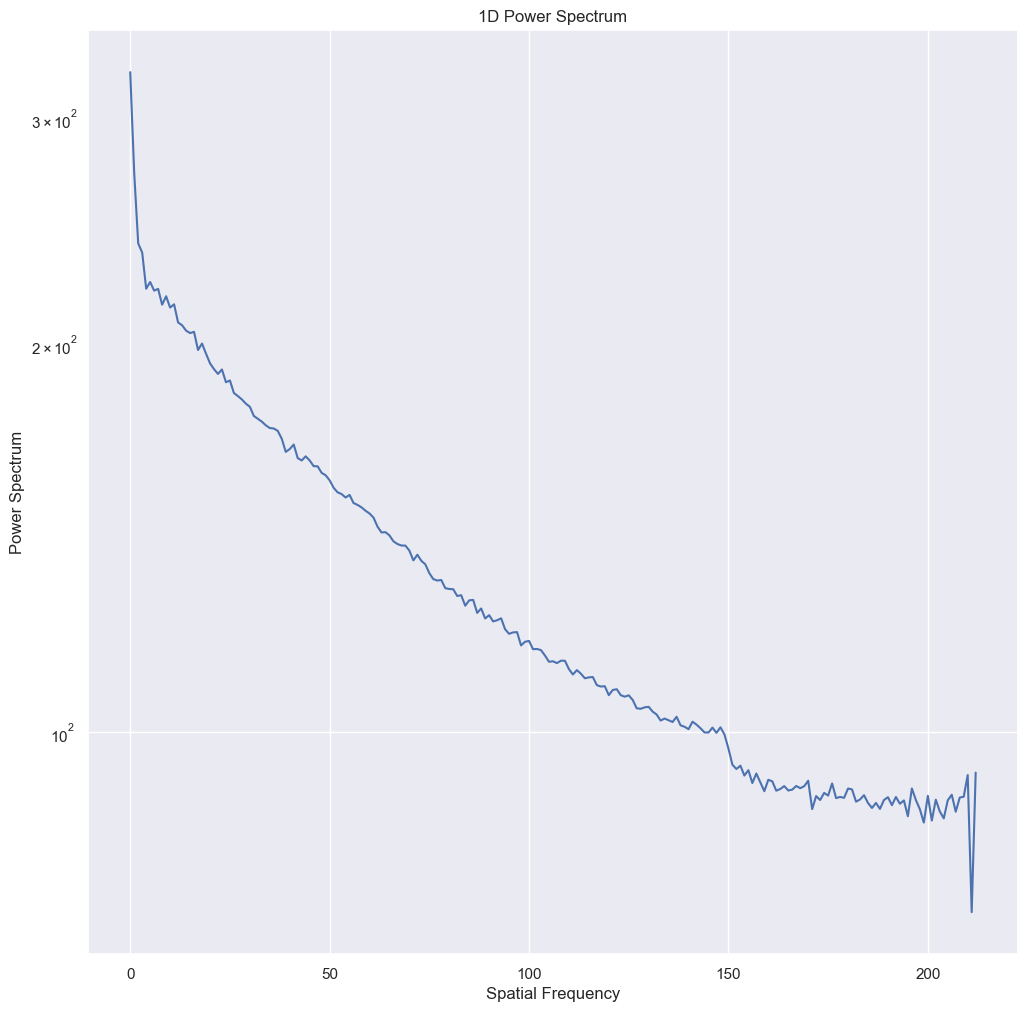

In [3]:
radial = calc.calc_radial_profile(img_fft2) # img_fft2 from previous step
plt.subplot(111), plt.semilogy(radial)
plt.title('1D Power Spectrum')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()

---
## Lorentz - TEST AREA !

pre-exponential factor = 24687.27 (+/-) 735.41
rate constant = 12.75 (+/-) 2.44
[ 2.46872704e+04  1.27457245e+01 -4.06332260e+03  1.64467788e+02
 -4.13157814e+02  8.23426652e-01  2.06747869e+03 -2.31182136e+00
  2.94206812e+03  4.65443195e+00  2.06679098e+03  3.60342950e+01]
[ 2.46872704e+04  1.27457245e+01 -4.06332260e+03  1.64467788e+02]


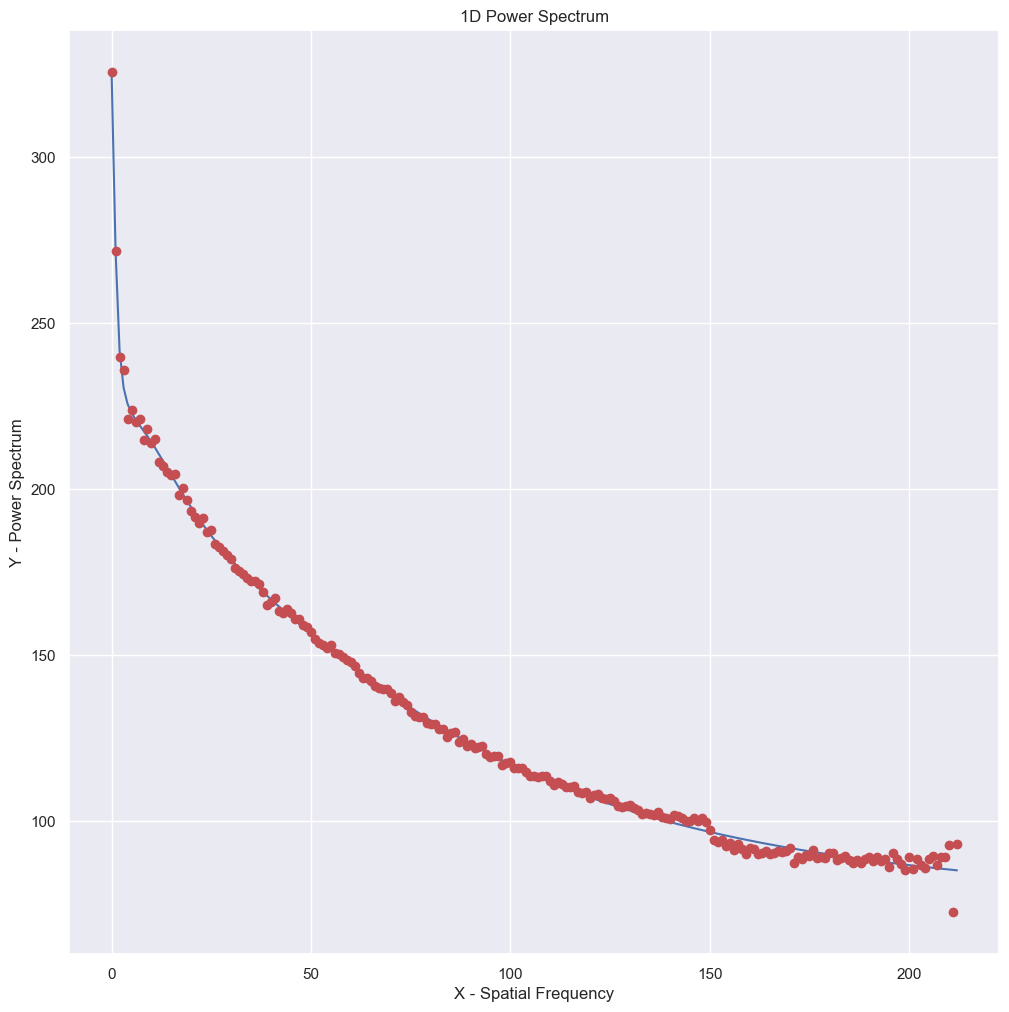

In [4]:
from image import image_read_gray
import calc
import numpy as np
from scipy.optimize import curve_fit

image = image_read_gray("../example/test_gray.png")
fft2_data = calc.fft2_transformer(image)

radial_data = calc.calc_radial_profile(fft2_data)

# Muss y0 bestimmt werden oder wird Wert bereits vorher festgelegt?
def lorentz(x, A, xc, y0, w):
    # A : Fläche unter dem Kurvenmaximum, Alpha Auswertung
    # w : Halbwertsbreite des Kurvenmaximums
    # y0 : Offset des Kurvenverlaufs
    # xc: Frequenz beim Amplitudenmaximum (Strukturgröße der Fleckigkeitsstörstellen)
    #y0 = 80
    return y0 + (2*A / np.pi) * (w / (4*(x-xc)**2 + w**2))

def _3lorentz(x, A1, xc1, y01, w1, A2, xc2, y02, w2, A3, xc3, y03, w3):
    return lorentz(x, A1, xc1, y01, w1) + lorentz(x, A2, xc2, y02, w2) + lorentz(x, A3, xc3, y03, w3)

length_x = np.shape(radial_data)
xdata = np.linspace(1, length_x[0], num=length_x[0])
ydata = radial_data


def c():
    area1 = 50
    amp1 = 25
    cen1 = 20
    wid1 = 10

    area2 = 50
    amp2 = 20
    cen2 = 10
    wid2 = 5

    area3 = 700
    amp3 = 100
    cen3 = 10
    wid3 = 20

    best_vals, covar = curve_fit(_3lorentz, xdata, ydata, p0=[area1, amp1, cen1, wid1, area2, amp2, cen2, wid2, area3, amp3, cen3, wid3], maxfev=2000)
    # we then can find the error of the fitting parameters
    # from the pcov_linear array
    perr_exponential = np.sqrt(np.diag(covar))
    # this cell prints the fitting parameters with their errors
    print("pre-exponential factor = %0.2f (+/-) %0.2f" % (best_vals[0], perr_exponential[0]))
    print("rate constant = %0.2f (+/-) %0.2f" % (best_vals[1], perr_exponential[1]))
    print(best_vals)

    plt.plot(_3lorentz(xdata, *best_vals))
    pars_1 = best_vals[:4]
    print(pars_1)
    #lorentz_peak_1 = lorentz(xdata, *pars_1)
    #print("area2 = %0.2f" % np.trapz(lorentz_peak_1))
    #plt.plot(lorentz_peak_1)
    #pars_2 = best_vals[3:6]
    #print(pars_2)
    #lorentz_peak_2 = lorentz(xdata, *pars_2)
    #print("area = %0.2f" % np.trapz(lorentz_peak_2))
    #plt.plot(lorentz_peak_2)
c()

plt.plot(ydata, "ro")
plt.title('1D Power Spectrum')
plt.xlabel('X - Spatial Frequency')
plt.ylabel('Y - Power Spectrum')
plt.show()


